# 1D Ising model

Let us consider the 1D Ising model defined by the Hamiltonian

$$
\mathcal{H} = -\sum_i S_i S_{i+1}
$$

with periodic boundary conditions.

When we update the $i$-the spin (using the procedure described in the previous section),
the energy difference of the two states can be computed as $\Delta E = E_\uparrow - E_\downarrow = - 2h$ with $O(1)$ operations.
Here, $h = S_{i-1} + S_{i+1}$ is the effective magnetic field acting on the $i$-th spin from the other spins (i.e., the nearest-neighbor spins).
Then, we take the state of $S_i=1$ with a probability of $1/(1+\exp(\beta \Delta E ))=1/(1+\exp(-2h\beta))$.

The values of the exponential function are precomputed and stored in memory to avoid expensive reevaluation.

In [18]:
@show VERSION
using BenchmarkTools, Random

VERSION = v"1.5.2"


## First simple implementation

Let us look at the implementation shown below.
The function ising1d! attempts to update each spin niters times.
This function will be compiled when it's called for the first time.
Thus, you must call it once before measuring its timings.
Or, you can simply use the macro @benchmark in BenchmarkTools,
which calles the function multiple times automatically.

In [19]:
function ising1d!(s, β, niters, rng)
    n = length(s)
    min_h = -2
    max_h = 2
    prob = [1/(1+exp(-2*β*h)) for h in min_h:max_h]
    #prob_f(h) = 1/(1+exp(-2*β*h))
    for iter in 1:niters, i in 1:n
        sl = s[ifelse(i == 1, n, i-1)]
        sr = s[ifelse(i == n, 1, i+1)]
        # h = -2, 0, 2
        h = sl + sr
        s[i] = ifelse(rand(rng) < prob[h-min_h+1], +1, -1)
        #s[i] = ifelse(rand(rng) < prob_f(h), +1, -1)
    end
end

num_spins = 100
rng = MersenneTwister(4649)
s0 = rand(rng, Int8[-1, 1], num_spins)
β = 10.0
niters = 10^3

s = copy(s0)

# Run once to compile the function
ising1d!(s, β, niters, rng)

@time ising1d!(s, β, niters, rng)
@benchmark ising1d!(s, β, niters, rng) setup=(s = copy(s0))

  0.000534 seconds (1 allocation: 128 bytes)


BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  1
  --------------
  minimum time:     406.253 μs (0.00% GC)
  median time:      415.124 μs (0.00% GC)
  mean time:        434.439 μs (0.00% GC)
  maximum time:     1.292 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

### Exercise 1

Check how the performance is affected without precomuting the exponential function.

## Complete implementation with measurement

Next, let us implement the measurement of observables such as magnetization and energy.
The magnetization and energy can be updated simultanously with the update of the spin configuration,
which costs only $O(1)$ operations.
If you compute the magnetization or energy from scratch,
it would cost $O(N)$ operations.

We explicity write the $S_i$ dependence of the total energy as 

$$
E(S_i) = - h S_i + E_0,
$$

where $h = S_{i-1} + S_{i+1}$ and $E_0$ is a constant that does not depend on $S_i$.


SpinState is a struct for storing a spin state and the values of associcated observables.
The data stored in a SpinState must be consistent throughout a Monte Carlo simulation.
It's not allowed to redefine a struct in the top-level scope.
Thus, the definition of the struc SpinState is wrapped in a module, to allow the redefinition of a struc.
This is convenient for doing trial and error.

We also define functions for computing the energy and magnetization,
which are used in many places.

In [20]:
# Wrap everything with a module to allow redefition of type
module MC

"""
Composite type to represent a spin state
"""
mutable struct SpinState
    num_spins::Int
    s::Array{Int8,1}
    energy::Int
    tot_mag::Int
end

"""
Energy
"""
function energy(s)
    n = length(s)
    - sum((s[i] * s[ifelse(i == n, 1, i+1)] for i in 1:n))
end

"""
Total magnetization
"""
total_magnetization(s) = sum(s)

"""
Constructor
"""
function SpinState(s)
    ss = SpinState(length(s), copy(s), energy(s), total_magnetization(s))
    sanity_check(ss)
    ss
end

"""
Sanity check
"""
function sanity_check(ss)
    @assert energy(ss.s) == ss.energy
    @assert total_magnetization(ss.s) == ss.tot_mag
end

"""
Take an object of SpinState as an input and update it in place.
"""
function update!(ss, β, niters, rng)
    min_h = -2
    max_h = 2
    s = ss.s
    n = ss.num_spins
    prob = [1/(1+exp(-2*β*h)) for h in min_h:max_h]
    for iter in 1:niters, i in 1:n
        sl = s[ifelse(i == 1, n, i-1)]
        sr = s[ifelse(i == n, 1, i+1)]
        # h = -2, 0, 2
        h = sl + sr
        si_old = s[i]
        s[i] = ifelse(rand(rng) < prob[h-min_h+1], +1, -1)
        
        # Update observables with O(1) operations
        ss.energy += (si_old - s[i]) * h
        ss.tot_mag += (s[i] - si_old)
    end
end

end
;

Let us perform a series of updates and check the consistency of the SpinState object.

In [21]:
ss = MC.SpinState(s0)
MC.update!(ss, β, niters, rng)
MC.sanity_check(ss)

In [22]:
@benchmark MC.update!(ss, β, niters, rng)

BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  1
  --------------
  minimum time:     442.059 μs (0.00% GC)
  median time:      451.933 μs (0.00% GC)
  mean time:        459.065 μs (0.00% GC)
  maximum time:     1.203 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

We now measure these observables during a Monte Carlo simulation.
Hereafter, $\langle O \rangle_\mathrm{MC}$ denotes a Monte Carlo average of an observable $O$.

Heat capacity/specific heat:

$$
C = \frac{\langle E^2\rangle_\mathrm{MC} - \langle E\rangle_\mathrm{MC}^2}{T^2}
$$

Squared magnetization ($\langle M\rangle_\mathrm{MC} = 0$ due to symmetries):

$$
M_2 = \langle M^2\rangle_\mathrm{MC}
$$

Magnetic susceptibility:

$$
\chi = \frac{\langle M^2\rangle_\mathrm{MC}}{T}
$$

As a prelude, we will create an "Accumulator" to easily store the results of multiple measurements of physical quantities.

In [40]:
module Meas

struct Accumulator
    count::Dict{String,UInt64}
    data::Dict{String,Any}
end

"""
Constructor
"""
function Accumulator()
    Accumulator(Dict{String,UInt64}(), Dict{String,Any}())
end

"""
Add a sample
"""
function add!(acc::Accumulator, name::String, data)
    if haskey(acc.count, name)
        acc.count[name] += 1
        acc.data[name] .+= data
    else
        acc.count[name] = 1
        acc.data[name] = copy(data)
    end
end

"""
Compuate mean
"""
function mean(acc::Accumulator, name::String)
    return acc.data[name]/acc.count[name]
end

end


# Perform some tests
let
    acc = Meas.Accumulator()
    Meas.add!(acc, "obs1", ones(4))
    Meas.add!(acc, "obs1", 2 .* ones(4))
    Meas.add!(acc, "obs2", ones(4))
    Meas.add!(acc, "obs2", ones(4))
    @assert Meas.mean(acc, "obs1") ≈ 1.5 .* ones(4)
    @assert Meas.mean(acc, "obs2") ≈ ones(4)
end

We measure every niters_meas Monte Carlo steps.
Every spin is attemped to be updated once in a signle Monte Carlo step.
We skip the first ntherm measurements.

In [24]:
function solve!(ss, acc, β, nsweeps, ntherm, niters_meas, rng)
    for isweep in 1:nsweeps
        MC.update!(ss, β, niters_meas, rng)
        if isweep <= ntherm
            continue
        end
        Meas.add!(acc, "E", Float64(ss.energy))
        Meas.add!(acc, "E2", Float64(ss.energy)^2)
        MC.sanity_check(ss)
    end
end


nsweeps = 100
niters_meas = 10
ntherm = ceil(nsweeps/10)
β = 1.0

ss = MC.SpinState(s0)
acc = Meas.Accumulator()
solve!(ss, acc, β, nsweeps, ntherm, niters_meas, rng)

println(Meas.mean(acc, "E"))
println(Meas.mean(acc, "E2"))

-75.55555555555556
5747.555555555556


We measure the specific heat with varying the temperature.

In [25]:
nsweeps = 10^6
num_spins = 100

rng = MersenneTwister(4649)
s0 = rand(rng, Int8[-1, 1], num_spins)

Ts_mc = range(0.4, 2, length=10)

C_mc = Float64[]
for T in Ts_mc
    ss = MC.SpinState(s0)
    acc = Meas.Accumulator()
    solve!(ss, acc, 1/T, nsweeps, ntherm, niters_meas, rng)
    E = Meas.mean(acc, "E")
    E2 = Meas.mean(acc, "E2")
    push!(C_mc, (E2-E^2)/T^2)
end

Let us compare Monte Carlo results with the exact solution $C/N = \frac{1}{T^2 \cosh^2(1/T)}$.

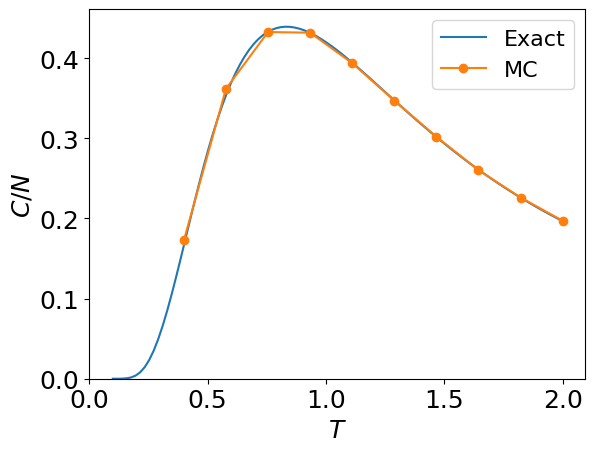

In [26]:
using PyPlot
Ts = range(0.1, 2, length=100)
exact_C(T) = 1/(T * cosh(1/T))^2
plt.plot(Ts, exact_C.(Ts), label="Exact")
plt.plot(Ts_mc, C_mc ./ num_spins, label="MC", marker="o")
plt.xlabel(raw"$T$")
plt.ylabel(raw"$C/N$")
plt.xlim([0, nothing])
plt.ylim([0, nothing])
plt.legend()
;

### Exercise 2
Measure the magnetic susceptibility and compare the results with the exact solution.

## Type stability of Accumulator

Type safe is an important concept to achieve high performance with Julia (see [officitial document](https://docs.julialang.org/en/v1/manual/performance-tips/)).
Actually, the Accumulator class implemented above is NOT type safe.
Let us see how crtitical it is and how to improve on it.
A convinient way to check the type stability of your code is using @code_warntype macro.

In [45]:
acc = Meas.Accumulator()
@code_warntype Meas.add!(acc, "obs1", ones(4)) 

Variables
  #self#::Core.Compiler.Const(Main.Meas.add!, false)
  acc::Main.Meas.Accumulator
  name::String
  data::Array{Float64,1}

Body::Any
1 ─ %1  = Base.getproperty(acc, :count)::Dict{String,UInt64}
│   %2  = Main.Meas.haskey(%1, name)::Bool
└──       goto #3 if not %2
2 ─ %4  = Base.getproperty(acc, :count)::Dict{String,UInt64}
│   %5  = Base.getindex(%4, name)::UInt64
│   %6  = (%5 + 1)::UInt64
│   %7  = Base.getproperty(acc, :count)::Dict{String,UInt64}
│         Base.setindex!(%7, %6, name)
│   %9  = Base.getproperty(acc, :data)::Dict{String,Any}
│   %10 = Base.dotview(%9, name)::Any
│   %11 = Base.getproperty(acc, :data)::Dict{String,Any}
│   %12 = Base.getindex(%11, name)::Any
│   %13 = Base.broadcasted(Main.Meas.:+, %12, data)::Any
│   %14 = Base.materialize!(%10, %13)::Any
└──       return %14
3 ─ %16 = Base.getproperty(acc, :count)::Dict{String,UInt64}
│         Base.setindex!(%16, 1, name)
│   %18 = Main.Meas.copy(data)::Array{Float64,1}
│   %19 = Base.getproperty(acc, :

In the above cells, you see many **Any**, which means that the Julia compiler failed to determine the type of some variable.
This is always about **striking a balance between performance and readability**.
Although I usually prefer the latter, it's your choice.
Let us see how badly the type instability affects the performance!

In [46]:
obs_val = ones(Float64, 100)
@benchmark Meas.add!(acc, "obs1", obs_val) 

BenchmarkTools.Trial: 
  memory estimate:  64 bytes
  allocs estimate:  2
  --------------
  minimum time:     390.597 ns (0.00% GC)
  median time:      413.199 ns (0.00% GC)
  mean time:        453.739 ns (0.35% GC)
  maximum time:     8.529 μs (94.19% GC)
  --------------
  samples:          10000
  evals/sample:     201

You can see that measuring a Float64 vector with 100 elements takes only 400 ns.
This unlikely affects the overall performance.